In [1]:
import os
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from random import sample
from time import time
from pathlib import Path
import zipfile

import numpy as np
from scipy.sparse import hstack, vstack

from sklearn.manifold import TSNE
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm

# Set plot properties
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({"font.size": 14})

In [2]:
# Paths using unzipped data
main_dir = Path("../../../data/")
netto_dir = main_dir / "english_netto_list"
rand_dir = main_dir / "english_random_sample"
comp_dir = main_dir / "english_complement"
clip_text = main_dir / "CLIP_without_images.pkl"
clip_images = main_dir / "CLIP_only_images.pkl"
clip_text_images = main_dir / "CLIP_with_images.pkl"

In [2]:
# Paths using zipped data
main_dir = Path("f:/datasets/PRV_KEMI_DATA/packaged_patents")
netto_dir = main_dir / "english_netto_list.zip"
rand_dir = main_dir / "english_random_sample.zip"
comp_dir = main_dir / "english_complement.zip"

# CLIP Paths
clip_root = Path("f:/datasets/PRV_KEMI_DATA/clip_repr_merged")
clip_text = clip_root / "CLIP_without_images.pkl"
clip_images = clip_root / "CLIP_only_images.pkl"
clip_text_images = clip_root / "CLIP_with_images.pkl"

# SBERT paths
sbert_root = Path("F:/datasets/PRV_KEMI_DATA/patent_sbert_merged")
sbert_text = sbert_root / "patent_sbert.pkl"

In [3]:
# Load JSON files
def load_json(path: Path):
    with open(path / "/patent_info.json", 'r') as f:
        data = json.load(f)
    return data

def collect_json(path: Path):
    if path.is_dir():
        patent_dirs = [d for d in path.iterdir() if d.is_dir()]
        return [load_json(d) for d in patent_dirs]
    elif path.suffix == '.zip':
        with zipfile.ZipFile(path) as pz:
            patent_info_files = [zipinfo for zipinfo in pz.infolist() if 'patent_info.json' in zipinfo.filename]
            patent_infos = []
            for patent_zipinfo in tqdm(patent_info_files, desc=f'Reading patents of {path.name}'):
                with pz.open(patent_zipinfo) as fp:
                    patent_info = json.load(fp)
                    patent_infos.append(patent_info)
        return patent_infos

        
def get_text(j, doc_part):
    return [d[doc_part]["en"] for d in j]


def get_ids(j):
    return [d['document_number'] for d in j]


# Build TF-IDF vectors
def tfidf_data(pos_path, neg_path, min_count=3, max_freq=0.2, balance=True, doc_parts=('abstract', 'description', 'claims')):
    # Parse JSON files
    pos_json = collect_json(pos_path)
    neg_json = collect_json(neg_path)
    if balance:
        # Balance data
        set_size = min(len(pos_json), len(neg_json))
        pos_json, neg_json = sample(pos_json, set_size), sample(neg_json, set_size)
        print(set_size, "examples per class")
    
    document_ids = get_ids(pos_json) + get_ids(neg_json)
    # Collect text fields
    vectorizers = dict()
    Xs = []
    feature_names = []
    for doc_part in doc_parts:
        documents = get_text(pos_json, doc_part) + get_text(neg_json, doc_part)
        
        # Build TF-IDF vectors using default tokenizer while discarding non-alphabetic tokens
        # Discard words that occur less than min_count times and in more than max_freq of documents
        tfidf_vectorizer = TfidfVectorizer(analyzer="word", stop_words="english", 
                                        token_pattern=r'(?u)\b[A-Za-z]+\b', min_df=min_count, max_df=max_freq)
        X = tfidf_vectorizer.fit_transform(documents)
        vectorizers[doc_part] = tfidf_vectorizer
        feature_names.extend([f'{doc_part[0].upper()}#{feature_name}' for feature_name in  tfidf_vectorizer.get_feature_names_out()])
        Xs.append(X)
    X = hstack(Xs)
    y = np.concatenate([np.ones(len(pos_json)), np.zeros(len(neg_json))])
    return X, y, feature_names, document_ids

In [4]:
# Load pickled CLIP data
def clip_data(path, pos_label, neg_label):
    with open(path, 'rb') as fp: 
        clip_data = pickle.load(fp)
    X, y = clip_data["X"], clip_data["y"]
    comp_index = (y==pos_label) | (y==neg_label)
    X = X[comp_index]
    y = [1 if i == pos_label else 0 for i in y[comp_index]]
    print(len(y), "examples in total")
    return X, y 

In [5]:
def sbert_data(path, pos_label, neg_label):
    with open(path, 'rb') as fp: 
        sbert_data = pickle.load(fp)
    X, y = sbert_data["X"], sbert_data["y"]
    comp_index = (y==pos_label) | (y==neg_label)
    X = X[comp_index]
    y = [1 if i == pos_label else 0 for i in y[comp_index]]
    print(len(y), "examples in total")
    return X, y

In [5]:
# Cross-validate KNN classifier
def knn_classify(X, y, k_min=1, k_max=49, k_step=2, num_splits=5):
    k_range = range(k_min, k_max+k_step, k_step)
    precision, recall, f1 = [], [], []
    for k in k_range:
        classifier = KNeighborsClassifier(n_neighbors=k)
        # Scores for binary targets where positive examples are assumed to have label 1
        scores = cross_validate(classifier, X, y, cv=num_splits, scoring=["precision", "recall", "f1"])
        precision.append(np.mean(scores["test_precision"]))
        recall.append(np.mean(scores["test_recall"]))
        f1.append(np.mean(scores["test_f1"]))
        print(int(k/k_range[-1]*100)*'|', end='\r')
    return k_range, precision, recall, f1

# Plot validation scores
def plot_scores(k_range, precision, recall, f1, title=None, with_labels=False, path=None):
    for (v, l) in [(precision, "Precision"), (recall, "Recall"), (f1, "F-score")]:
        if with_labels: plt.plot(k_range, v, label=l)
        else: plt.plot(k_range, v)
    plt.xlabel("k")
    plt.ylabel("Score")
    if with_labels: plt.legend()
    if title != None: plt.title(title)
    plt.tight_layout()
    if path != None: plt.savefig(path)
    plt.show()

In [6]:
X_tfidf_rand, y_tfidf_rand, rand_feature_names, rand_doc_numbers = tfidf_data(netto_dir, rand_dir)
X_tfidf_comp, y_tfidf_comp, comp_feature_names, comp_doc_numbers = tfidf_data(netto_dir, comp_dir)

Reading patents of english_netto_list.zip:   0%|          | 0/7684 [00:00<?, ?it/s]

Reading patents of english_random_sample.zip:   0%|          | 0/8331 [00:00<?, ?it/s]

7684 examples per class


Reading patents of english_netto_list.zip:   0%|          | 0/7684 [00:00<?, ?it/s]

Reading patents of english_complement.zip:   0%|          | 0/6978 [00:00<?, ?it/s]

6978 examples per class


In [48]:
len(feature_names)

134147

Reading patents of english_netto_list.zip:   0%|          | 0/7684 [00:00<?, ?it/s]

Reading patents of english_random_sample.zip:   0%|          | 0/8331 [00:00<?, ?it/s]

7684 examples per class


Reading patents of english_netto_list.zip:   0%|          | 0/7684 [00:00<?, ?it/s]

Reading patents of english_complement.zip:   0%|          | 0/6978 [00:00<?, ?it/s]

6978 examples per class


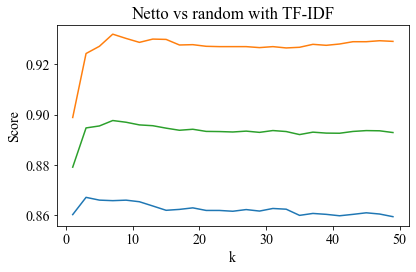

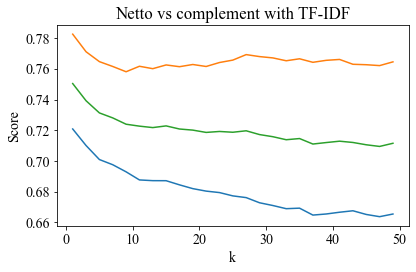

In [13]:
# Evaluate TF-IDF representations and KNN classifier
#netto_path = main_dir+netto_dir

for (X, y, title, file_name) in \
    [(X_tfidf_rand, y_tfidf_rand, "Netto vs random with TF-IDF", "tfidf_random_nl.pdf"),
     (X_tfidf_comp, y_tfidf_comp, "Netto vs complement with TF-IDF", "tfidf_complement_nl.pdf")]:
    k_range, precision, recall, f1 = knn_classify(X, y)
    plot_scores(k_range, precision, recall, f1, title, False, main_dir / file_name)

In [ ]:
# Evaluate CLIP representations and KNN classifier
for (neg_label, in_file, out_file, title) in \
    [(1, clip_text, "clip_text_complement_nl.pdf", "Netto vs complement with CLIP text"),
     (2, clip_text, "clip_text_random_nl.pdf", "Netto vs random with CLIP text"),
     (1, clip_images, "clip_images_complement_nl.pdf", "Netto vs complement with CLIP images"),
     (2, clip_images, "clip_images_random_nl.pdf", "Netto vs random with CLIP images"),
     (1, clip_text_images, "clip_text_images_complement_nl.pdf", "Netto vs complement with CLIP text/images"),
     (2, clip_text_images, "clip_text_images_random_nl.pdf", "Netto vs random with CLIP text/images")]:
    X, y = clip_data(in_file, 0, neg_label)
    k_range, precision, recall, f1 = knn_classify(X, y)
    plot_scores(k_range, precision, recall, f1, title, False, main_dir / out_file)

14662 examples in total


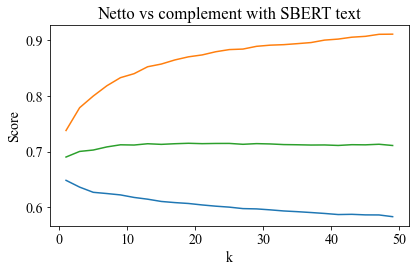

15796 examples in total


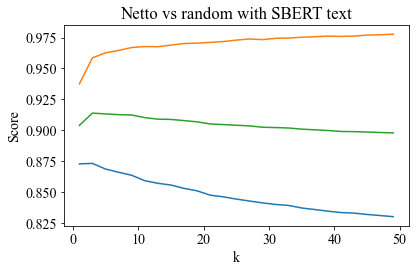

In [41]:
# Evaluate SBERT representations and KNN classifier
for (neg_label, in_file, out_file, title) in \
    [(1, sbert_text, "sbert_text_complement_nl.pdf", "Netto vs complement with SBERT text"),
     (2, sbert_text, "sbert_text_random_nl.pdf", "Netto vs random with SBERT text"),
     ]:
    X, y = sbert_data(in_file, 0, neg_label)
    k_range, precision, recall, f1 = knn_classify(X, y)
    plot_scores(k_range, precision, recall, f1, title, False, main_dir / out_file)

In [140]:
import csv

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


comparisons = [
    (X_tfidf_rand, y_tfidf_rand, "Netto vs random with TF-IDF",  "tfidf_random_nl.csv"), 
    (X_tfidf_comp, y_tfidf_comp, "Netto vs complement with TF-IDF",  "tfidf_complement_nl.csv"),
    (*sbert_data(sbert_text, pos_label=0, neg_label=1), "Netto vs complement with SBERT text", "sbert_text_complement_nl.csv"),
    (*sbert_data(sbert_text, pos_label=0, neg_label=2), "Netto vs random with SBERT text", "sbert_text_random_nl.csv"),
    (*clip_data(clip_text, pos_label=0, neg_label=1), "Netto vs complement with CLIP text", "clip_text_complement_nl.csv"),
    (*clip_data(clip_text, pos_label=0, neg_label=2), "Netto vs random with CLIP text", "clip_text_random_nl.csv"),
    (*clip_data(clip_images, pos_label=0, neg_label=1), "Netto vs complement with CLIP images", "clip_images_complement_nl.csv"),
    (*clip_data(clip_images, pos_label=0, neg_label=1), "Netto vs random with CLIP images", "clip_images_random_nl.csv"),
    (*clip_data(clip_text_images, pos_label=0, neg_label=1), "Netto vs complement with CLIP text/images", "clip_text_images_complement_nl.csv"),
    (*clip_data(clip_text_images, pos_label=0, neg_label=2), "Netto vs random with CLIP text/images", "clip_text_images_random_nl.csv")
    ]
     
def get_cv_scores(X, y, classifier, num_splits=5):
    metrics = ["precision", "recall", "f1", "roc_auc"]
    scores = cross_validate(classifier, X, y, cv=num_splits, scoring=metrics)
    scores_rows = []
    for i in range(num_splits):
        score_row =  dict(classifier=type(classifier).__name__, num_splits=num_splits)
        for metric in metrics:
            score = scores[f'test_{metric}'][i]
            score_row[metric] = score
        scores_rows.append(score_row)
    return scores_rows

classifiers = [ 
                (LogisticRegression, tuple(), dict(max_iter=200, dual=True, solver='liblinear', C=0.1)),
                (RandomForestClassifier, tuple(), dict(n_estimators=100)),
                #(SVC, tuple(), dict(C=0.1)),
            ]

output_dir = Path('f:/datasets/PRV_KEMI_DATA/classification_results')
output_dir.mkdir(exist_ok=True, parents=True)

with open(output_dir / 'collated_results.csv', 'w', newline='') as collated_fp:
    collated_csv_writer = None
    for (X, y, title, file_name) in tqdm(comparisons, desc="Comparisons"):
        scores = []
        for (classifier_class, classifier_args, classifier_kwargs) in classifiers:
            classifier = classifier_class(*classifier_args, **classifier_kwargs)
            classifier_scores = get_cv_scores(X, y, classifier)
            for score_row in classifier_scores:
                score_row['title'] = title
                scores.append(score_row)
        
        with open(output_dir / file_name, 'w', newline='') as fp:
            fieldnames = scores[0].keys()
            csv_writer = csv.DictWriter(fp, fieldnames=fieldnames)
            csv_writer.writeheader()
            if collated_csv_writer is None:
                collated_csv_writer = csv.DictWriter(collated_fp, fieldnames=fieldnames)
                collated_csv_writer.writeheader()
            for classifier_scores in scores:
                csv_writer.writerow(classifier_scores)
                collated_csv_writer.writerow(classifier_scores)

14662 examples in total
15796 examples in total
14443 examples in total
15915 examples in total
13040 examples in total
13040 examples in total
13040 examples in total
15085 examples in total


Comparisons:   0%|          | 0/10 [00:00<?, ?it/s]

F:\Anaconda\envs\prv_kemi\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
F:\Anaconda\envs\prv_kemi\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
F:\Anaconda\envs\prv_kemi\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
F:\Anaconda\envs\prv_kemi\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
F:\Anaconda\envs\prv_kemi\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
F:\Anaconda\envs\prv_kemi\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the n

In [141]:
import pandas as pd
import seaborn as sns
collated_results = pd.read_csv(output_dir / 'collated_results.csv')
collated_results

,classifier,num_splits,precision,recall,f1,roc_auc,title
0,LogisticRegression,5,0.899687,0.933637,0.916347,0.966562,Netto vs random with TF-IDF
1,LogisticRegression,5,0.915593,0.924528,0.920039,0.967801,Netto vs random with TF-IDF
2,LogisticRegression,5,0.910726,0.922576,0.916613,0.966120,Netto vs random with TF-IDF
3,LogisticRegression,5,0.911482,0.924528,0.917959,0.969245,Netto vs random with TF-IDF
4,LogisticRegression,5,0.923423,0.934245,0.928803,0.974187,Netto vs random with TF-IDF
...,...,...,...,...,...,...,...
95,RandomForestClassifier,5,0.899785,0.908894,0.904317,0.969951,Netto vs random with CLIP text/images
96,RandomForestClassifier,5,0.913818,0.927693,0.920703,0.973024,Netto vs random with CLIP text/images
97,RandomForestClassifier,5,0.892562,0.937771,0.914608,0.968456,Netto vs random with CLIP text/images
98,RandomForestClassifier,5,0.899788,0.922576,0.911040,0.966723,Netto vs random with CLIP text/images


C:\Users\Erik\AppData\Local\Temp/ipykernel_27236/84320500.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


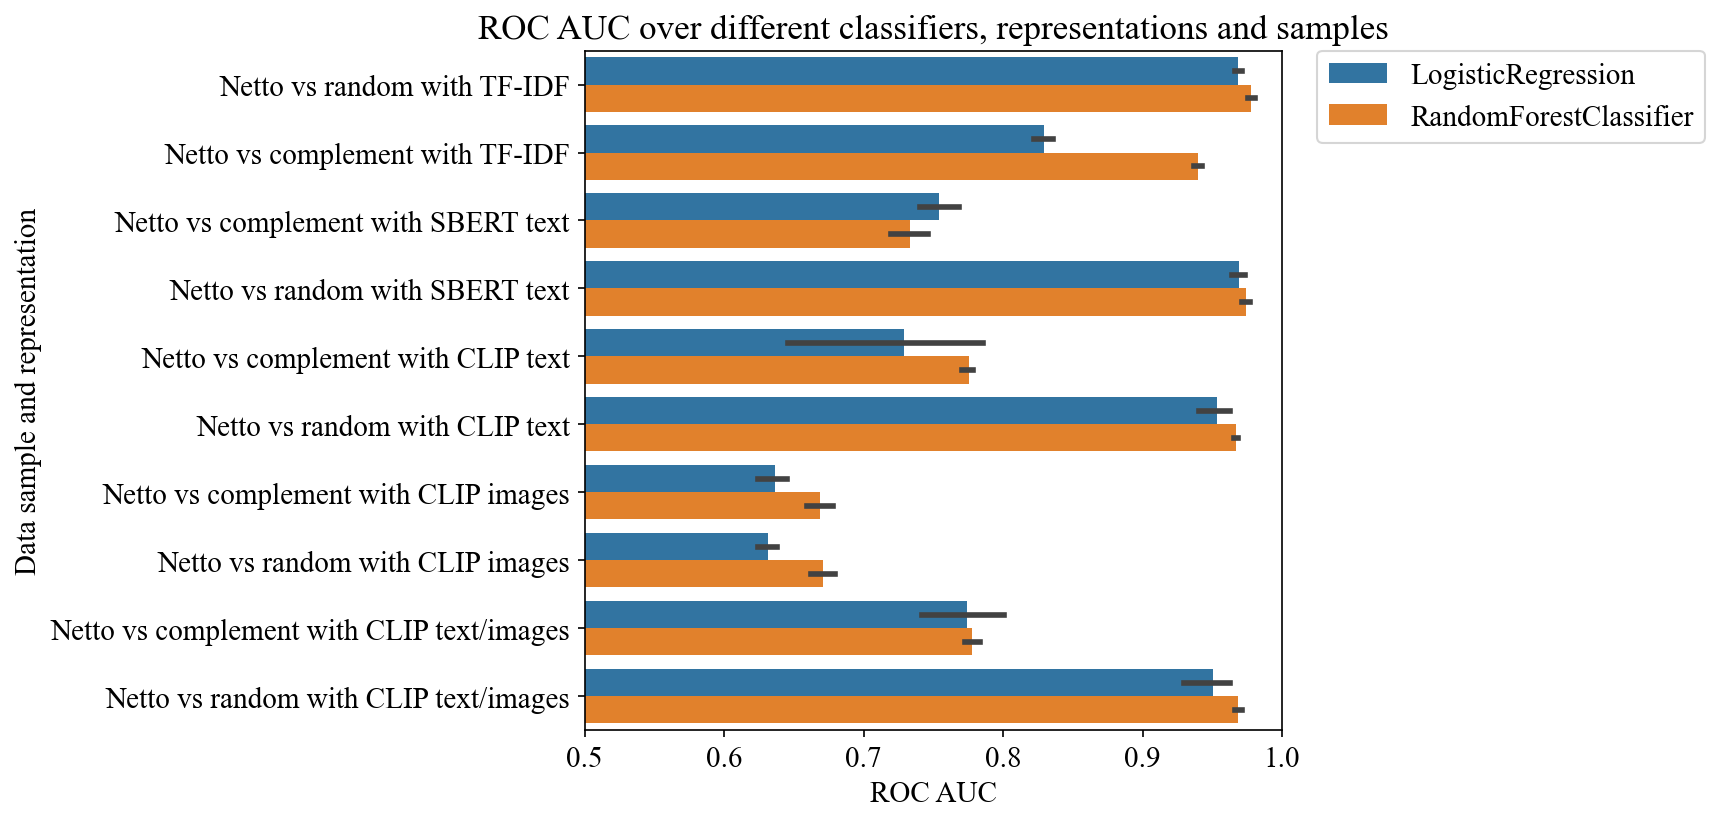

In [142]:
fig = plt.figure(figsize=(6,6), dpi=150)
sns.barplot(data=collated_results, y='title', x='roc_auc', hue='classifier')
plt.title('ROC AUC over different classifiers, representations and samples')
plt.xlabel('ROC AUC')
plt.ylabel('Data sample and representation')
plt.xlim(0.5, 1.0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
fig.savefig(output_dir / 'classificer_roc_auc.png', bbox_inches='tight')
#plt.xticks(plt.xticks()[0], rotation=70)

C:\Users\Erik\AppData\Local\Temp/ipykernel_27236/987022424.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


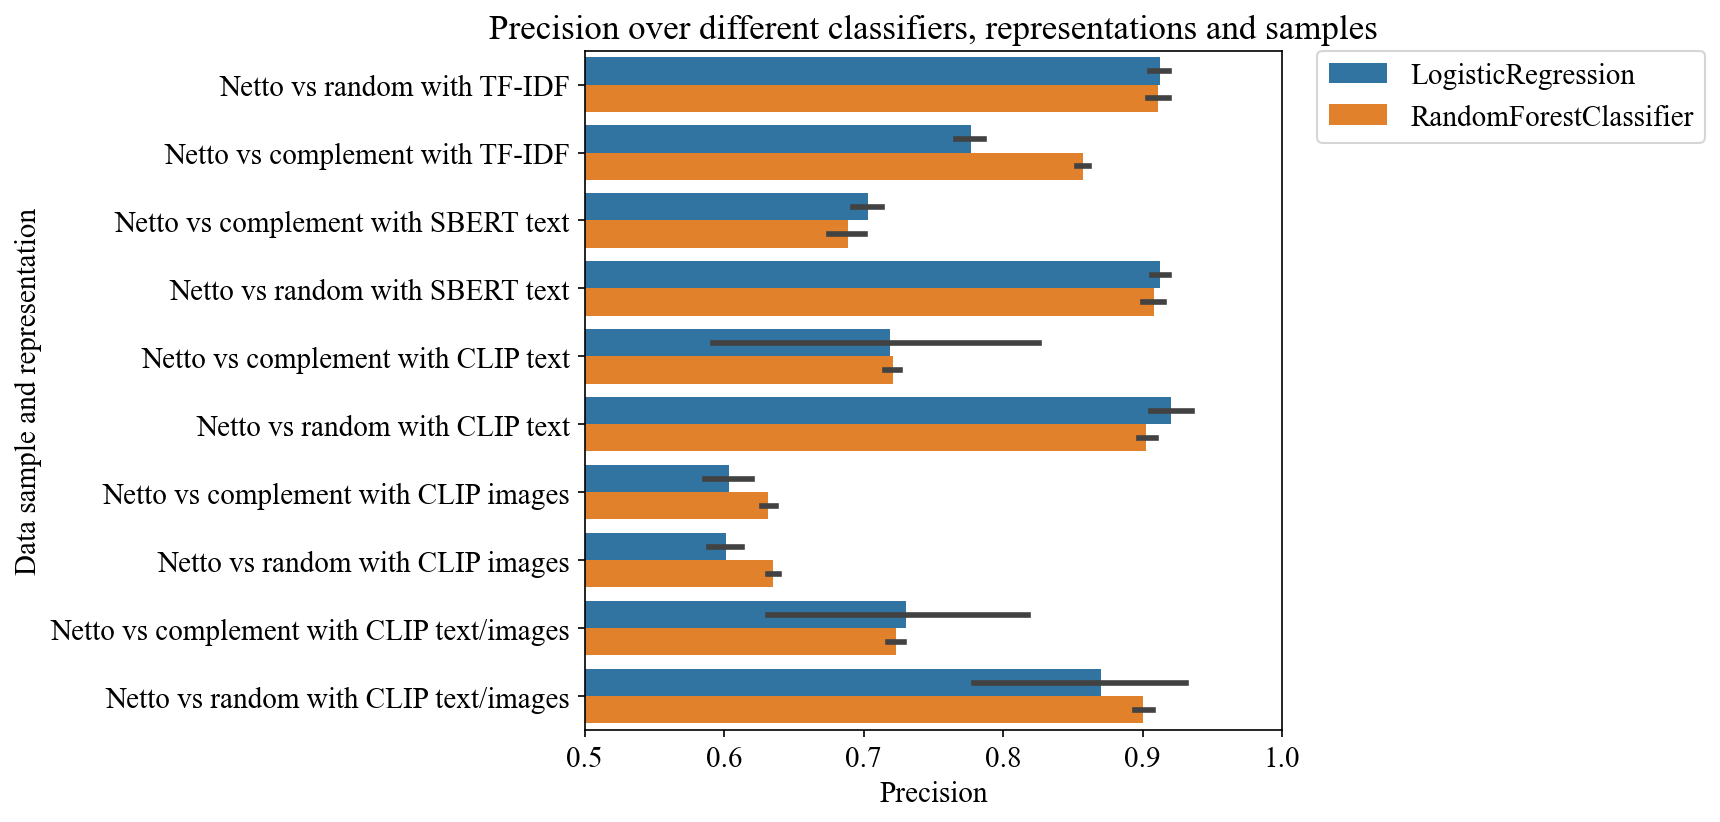

In [143]:
fig = plt.figure(figsize=(6,6), dpi=150)
sns.barplot(data=collated_results, y='title', x='precision', hue='classifier')
plt.title('Precision over different classifiers, representations and samples')
plt.xlabel('Precision')
#plt.ylabel('Data sample and representation')
plt.ylabel('')
plt.xlim(0.5, 1.0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
fig.savefig(output_dir / 'classificer_precision.png', bbox_inches='tight')
#plt.xticks(plt.xticks()[0], rotation=70)

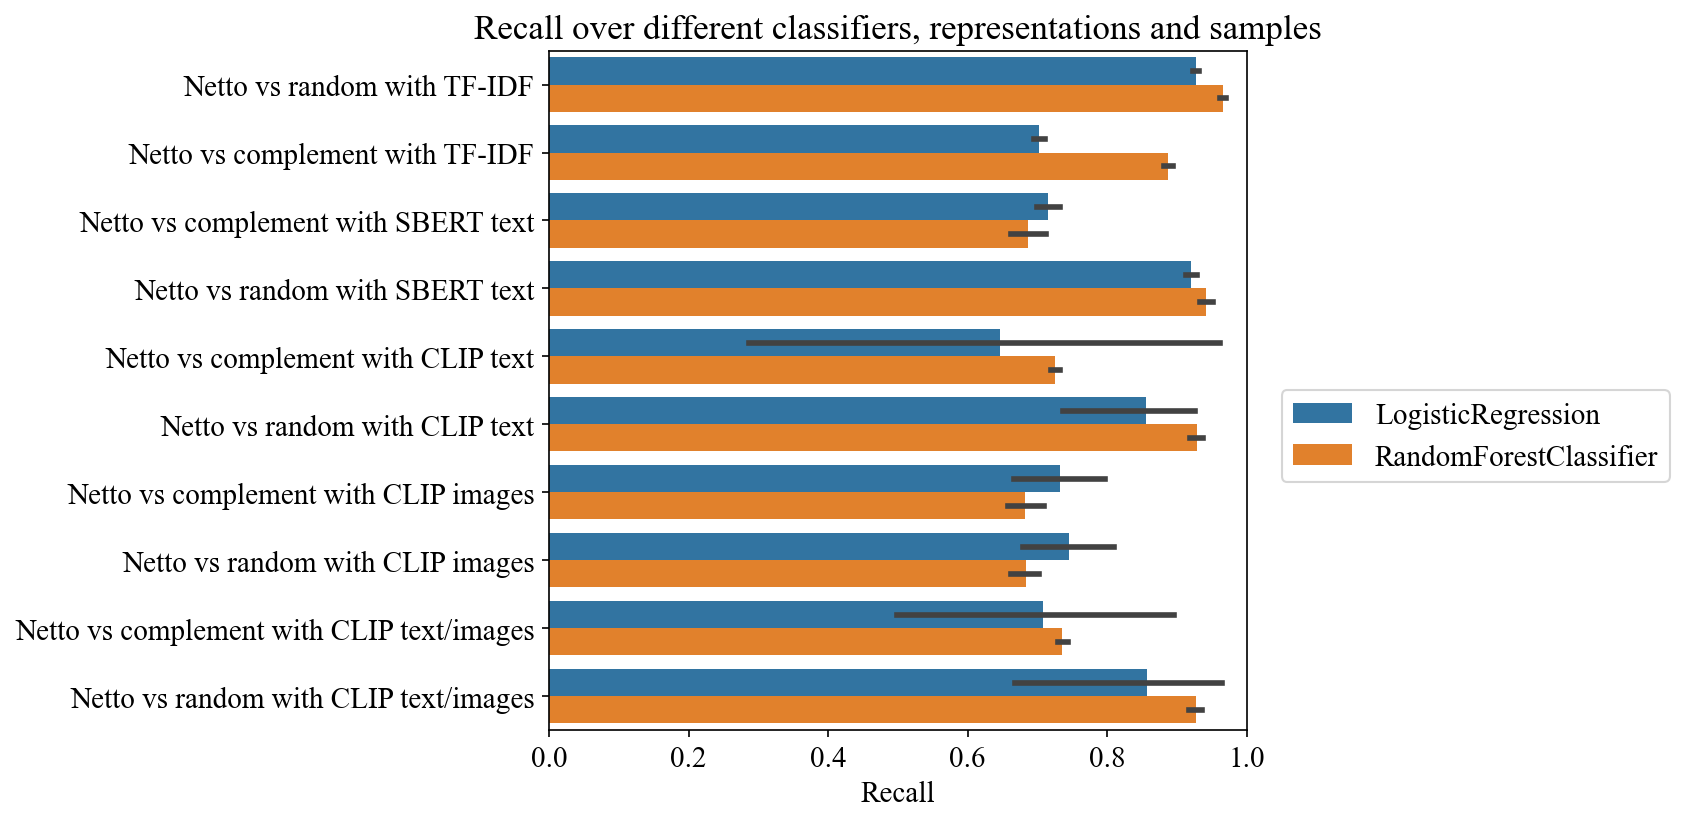

In [149]:
fig = plt.figure(figsize=(6,6), dpi=150)
sns.barplot(data=collated_results, y='title', x='recall', hue='classifier')
plt.title('Recall over different classifiers, representations and samples')
plt.xlabel('Recall')
#plt.ylabel('Data sample and representation')
plt.ylabel('')
plt.xlim(0, 1.0)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='upper left', borderaxespad=0)
fig.savefig(output_dir / 'classificer_recall.png', bbox_inches='tight')
#plt.xticks(plt.xticks()[0], rotation=70)

In [52]:
import csv

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
comparisons = [
    (X_tfidf_rand, y_tfidf_rand, rand_doc_numbers, "Netto vs random with TF-IDF",  "tfidf_random_missclassifications_per_label.txt"),
    (X_tfidf_comp, y_tfidf_comp, comp_doc_numbers, "Netto vs complement with TF-IDF",  "tfidf_complement_missclassification_per_label.txt"),
]

output_dir = Path('f:/datasets/PRV_KEMI_DATA/classification_results/missclassifications')
output_dir.mkdir(exist_ok=True, parents=True)


feature_importances_by_title = dict()

for (X, y, doc_numbers, title, file_name) in comparisons:
    X = X.tocsr()
    prediction_indices = []
    prediction_goodness = []
    feature_importances = []

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        classifier = LogisticRegression(dual=True, solver='liblinear')
        classifier.fit(X_train, y_train)
        positive_class = np.argwhere(classifier.classes_==1).squeeze()
        # make the labels -1, +1. If we then multiply the predicted logits with these labels, "correct" predictions will be positive, and incorrect negative. We can then order incorrect prediction by the logit to find the most incorrect ones
        y_test_signed = y_test*2 - 1 
        y_hat_test = classifier.predict_log_proba(X_test)[:, positive_class]  # We get one column of scores per class, here we only look at the positive
        goodness_scores = y_hat_test * y_test_signed
        
        prediction_indices.extend(test_index)
        prediction_goodness.extend(goodness_scores)
        feature_importances.append(classifier.coef_)
    
    feature_importances_by_title[title] = np.concatenate(feature_importances, axis=0).mean(axis=0)

    prediction_goodness = np.array(prediction_goodness)
    prediction_indices = np.array(prediction_indices)
    goodness_sort_index = np.argsort(prediction_goodness)
    sorted_goodness = prediction_goodness[goodness_sort_index]
    sorted_indices = prediction_indices[goodness_sort_index]
    positive_missclassified = []
    negative_missclassified = []
    n_missclassified = 20
    for idx in sorted_indices:
        if len(positive_missclassified) >= n_missclassified and len(negative_missclassified) >= n_missclassified:
            break
        label = y[idx]
        doc_number = doc_numbers[idx]
        if label == 1 and len(positive_missclassified) < n_missclassified:
            positive_missclassified.append(doc_number)
        elif label == 0 and len(negative_missclassified) < n_missclassified:
            negative_missclassified.append(doc_number)

    with open(output_dir / file_name, 'w') as fp:
        fp.write(f"20 most missclassified for {title}\n")
        fp.write(f"  positive: {positive_missclassified}\n")
        fp.write(f"  negative: {negative_missclassified}\n")

In [53]:
feature_importances_by_title



{'Netto vs random with TF-IDF': array([0.03728496, 0.09294315, 0.08704202, ..., 0.03027063, 0.03919236,
        0.02567291]),
 'Netto vs complement with TF-IDF': array([-0.02584024,  0.0306245 ,  0.14678   , ...,  0.11288233,
         0.05898498,  0.01918353])}

In [22]:
mean_imp = stacked_feature_importances.mean(axis=0)
idx_sorted_imp = np.argsort(mean_imp)

In [68]:
def plot_importance(title, mean_imp, feature_names, ax, n=25):
    idx_sorted_imp = np.argsort(mean_imp)
    most_negative_names = [feature_names[i] for i in idx_sorted_imp[:n]]
    most_negative_scores = mean_imp[idx_sorted_imp[:n]]
    most_positive_names = [feature_names[i] for i in idx_sorted_imp[-n:]]
    most_positive_scores = mean_imp[idx_sorted_imp[-n:]]
    neg_x = np.arange(-len(most_negative_scores),0)
    ax.barh(neg_x, most_negative_scores, color='red')
    pos_x = np.arange(len(most_positive_scores))
    ax.barh(pos_x, most_positive_scores, color='blue')
    x = np.concatenate((neg_x, pos_x))
    ax.set_yticks(x)
    ax.set_yticklabels(most_negative_names + most_positive_names, rotation=0)
    ax.set_title(title + f'\n{n} most negative and positive coefficients')
    ax.set_xlabel('Coefficient value')
    ax.set_ylabel('Corresponding word (A# - abstract, D# - description, C# - claims)')

In [93]:
def plot_importance_subplots(title, mean_imp, feature_names, fig, ax_neg, ax_pos, n=15):
    idx_sorted_imp = np.argsort(mean_imp)
    most_negative_names = [feature_names[i] for i in idx_sorted_imp[:n]]
    most_negative_scores = mean_imp[idx_sorted_imp[:n]]
    most_positive_names = [feature_names[i] for i in idx_sorted_imp[-n:]]
    most_positive_scores = mean_imp[idx_sorted_imp[-n:]]
    neg_x = np.arange(-len(most_negative_scores),0)
    ax_neg.barh(neg_x, most_negative_scores, color='red')
    pos_x = np.arange(len(most_positive_scores))
    ax_pos.barh(pos_x, most_positive_scores, color='blue')
    #x = np.concatenate((neg_x, pos_x))
    ax_neg.set_yticks(neg_x)
    ax_neg.set_yticklabels(most_negative_names, rotation=0)
    ax_pos.set_yticks(pos_x)
    ax_pos.set_yticklabels(most_positive_names)
    fig.suptitle(title + f'\n{n} most negative and positive coefficients')
    ax_neg.set_xlabel('Coefficient value')
    ax_pos.set_xlabel('Coefficient value')
    ax_neg.set_ylabel('Corresponding word (A# - abstract, D# - description, C# - claims)')
    plt.tight_layout()

In [41]:
n = 25
most_negative_names = [rand_feature_names[i] for i in idx_sorted_imp[:n]]
most_negative_scores = mean_imp[idx_sorted_imp[:n]]
most_positive_names = [rand_feature_names[i] for i in idx_sorted_imp[-n:]]
most_positive_scores = mean_imp[idx_sorted_imp[-n:]]

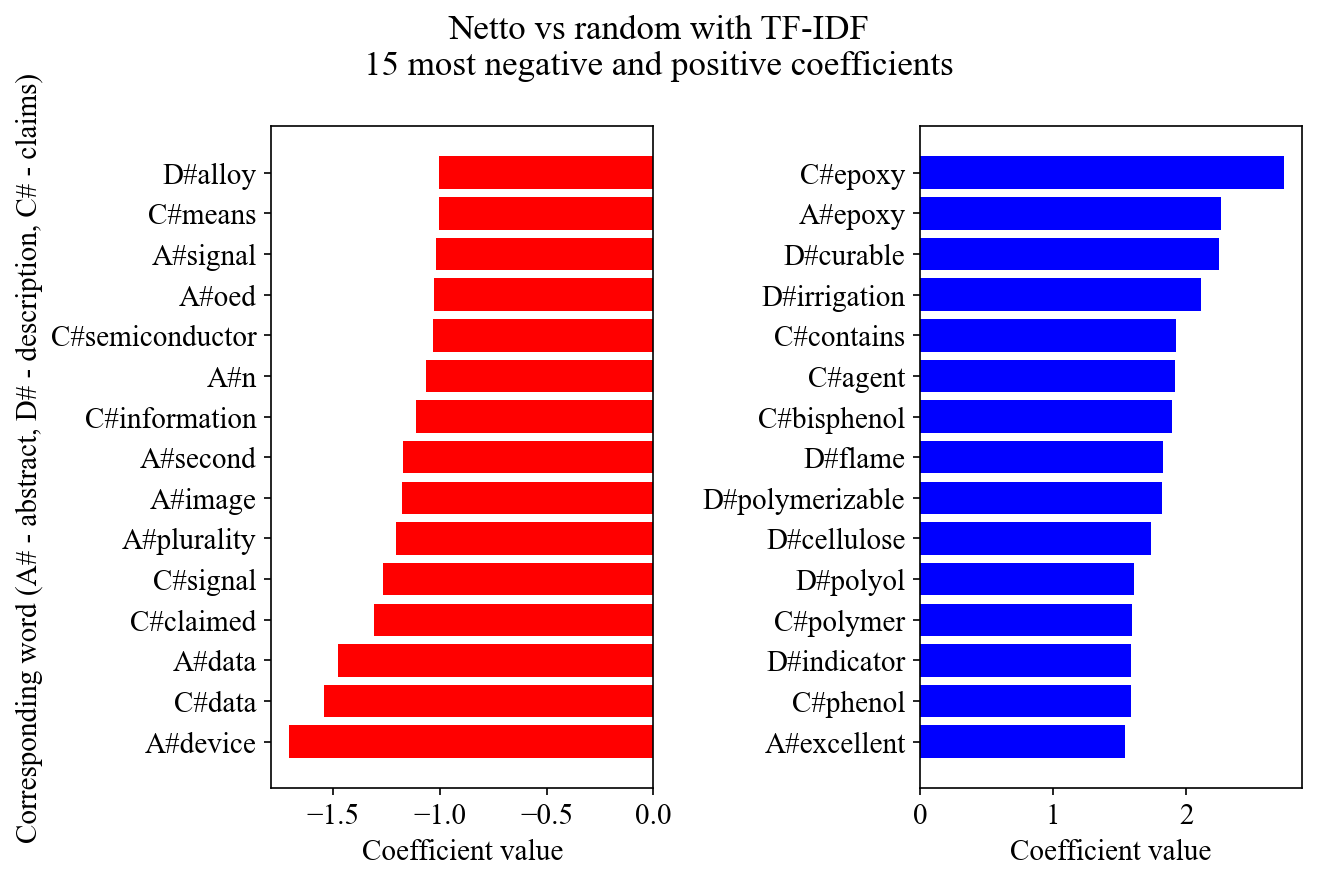

In [100]:
fig, [ax_neg, ax_pos] = plt.subplots(1, 2, figsize=(9,6), dpi=150)
plot_importance_subplots('Netto vs random with TF-IDF', feature_importances_by_title['Netto vs random with TF-IDF'], rand_feature_names, fig, ax_neg, ax_pos)
fig.savefig(output_dir / 'netto_vs_random_feature_importance.png')


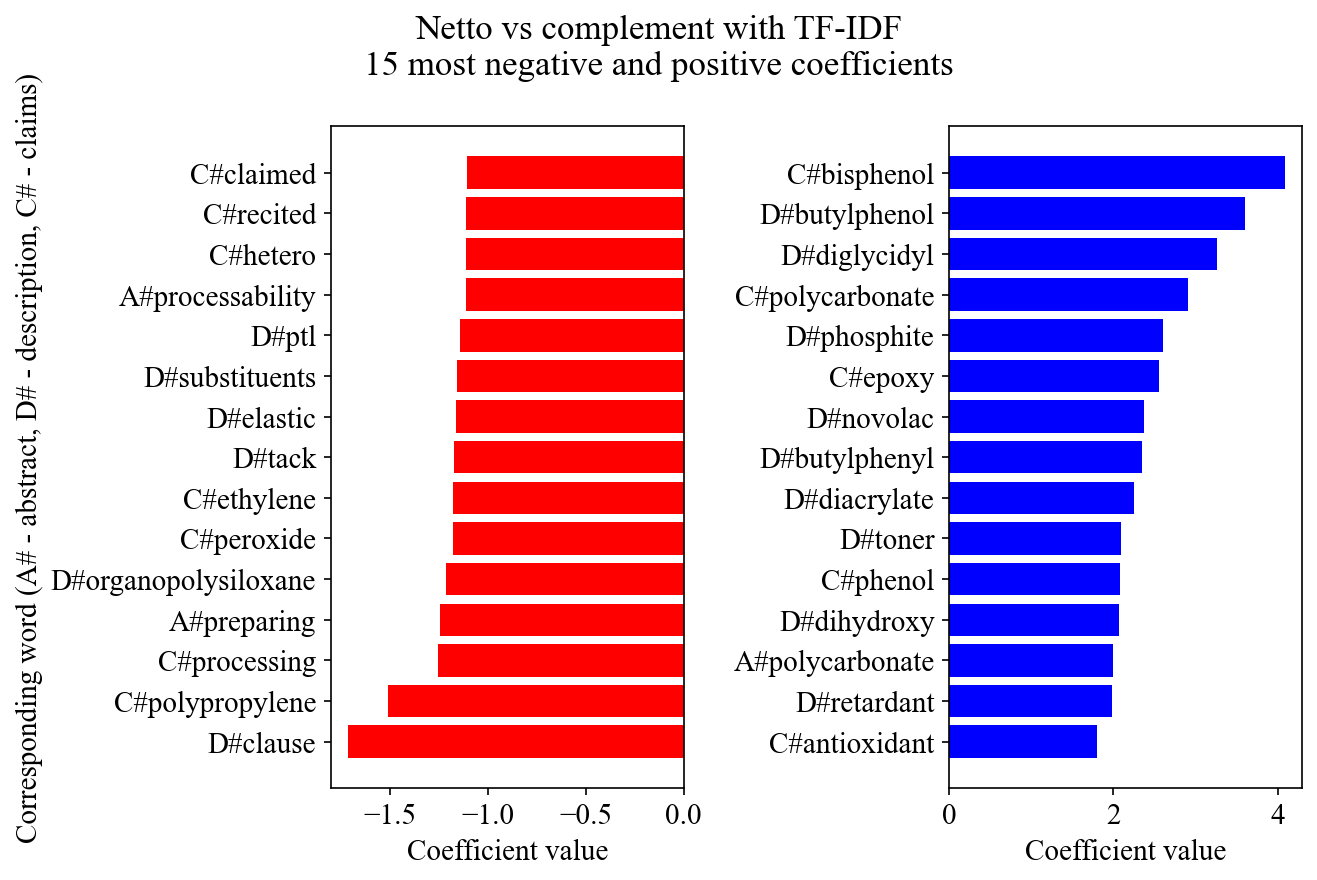

In [101]:
fig, [ax_neg, ax_pos] = plt.subplots(1, 2, figsize=(9, 6), dpi=150)
plot_importance_subplots('Netto vs complement with TF-IDF', feature_importances_by_title['Netto vs complement with TF-IDF'], comp_feature_names, fig, ax_neg, ax_pos)
fig.savefig(output_dir / 'netto_vs_complement_feature_importance.png')

In [64]:
ten_most_missclassified

[(1.0, 'EP2960230.A1'),
 (1.0, 'EP2960230.A1'),
 (0.0, 'EP2829568.A1'),
 (0.0, 'EP2829568.A1'),
 (1.0, 'EP2792712.A1'),
 (1.0, 'EP2792712.A1'),
 (1.0, 'EP3228643.A2'),
 (1.0, 'EP3228643.A2'),
 (1.0, 'EP2898950.A1'),
 (1.0, 'EP2898950.A1')]